### **Mise En Garde: Certaines méthodes sont exploitables en fonction de la version de Python que vous ustilisez**

In [ ]:
!pip install pyspark

In [2]:
import pyspark
print(f"{pyspark.__version__}")

3.5.0


In [3]:
import os
os.listdir(os.getcwd())

['.config', 'census_income.csv', 'sample_data']

### **Point d'entrée : SparkContext**

In [4]:
sc = pyspark.SparkContext()

# Verifier si SparkContext est valide
print(sc)

<SparkContext master=local[*] appName=pyspark-shell>


In [5]:
# Check the version of SparkContext in PySpark Shell
print("La version de Spark Context dans PySpark Shell est : ", sc.version)

# Display the Python version of SparkContext
print("La version Python de Spark Context dans PySpark Shell est : ", sc.pythonVer)

# Display the master of SparkContext
print("Le maitre de Spark Context dans PySpark Shell est : ", sc.master)

La version de Spark Context dans PySpark Shell est :  3.5.0
La version Python de Spark Context dans PySpark Shell est :  3.10
Le maitre de Spark Context dans PySpark Shell est :  local[*]


### **Loading Data**

In [6]:
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)

In [60]:
forest_path = 'forest_coverage_type.csv'

forest = spark.read.csv(forest_path, header=True, inferSchema=True)

In [61]:
forest.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+---------------------+---------------------+------------------------+-----------------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Hori

In [62]:
forest.printSchema()

root
 |-- Elevation: integer (nullable = true)
 |-- Aspect: integer (nullable = true)
 |-- Slope: integer (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
 |-- Vertical_Distance_To_Hydrology: integer (nullable = true)
 |-- Horizontal_Distance_To_Roadways: integer (nullable = true)
 |-- Hillshade_9am: integer (nullable = true)
 |-- Hillshade_Noon: integer (nullable = true)
 |-- Hillshade_3pm: integer (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
 |-- Wilderness_Area_Rawah: integer (nullable = true)
 |-- Wilderness_Area_Neota: integer (nullable = true)
 |-- Wilderness_Area_Comanche: integer (nullable = true)
 |-- Wilderness_Area_CacheLaPoudre: integer (nullable = true)
 |-- Soil_type_2702: integer (nullable = true)
 |-- Soil_type_2703: integer (nullable = true)
 |-- Soil_type_2704: integer (nullable = true)
 |-- Soil_type_2705: integer (nullable = true)
 |-- Soil_type_2706: integer (nullable = true)
 |-- Soil_type_2

### **Introducing Transformers**

List of most popular **Transformers**
* Binarizer
* Bucketizer
* ChiSqSelector
* CountVectorizer
* DCT
* ElementwiseProduct
* HashingTF
* IDF
* IndexToString
* MaxAbsScaler
* MinMaxScaler
* NGram
* Normalizer
* OneHotEncoder
* PCA
* PolynomialExpansion
* QuantileDiscretizer
* RegexTokenizer
* RFormula
* SQLTransformer
* StandardScaler
* StopWordsRemover
* StringIndexer
* Tokenizer
* VectorAssembler
* VectorIndexer
* VectorSlicer
* Word2Vec

In [63]:
import pyspark.sql.functions as f
import pyspark.ml.feature as feat
import numpy as np

### **Bucketize**



In [66]:
buckets_no = 10

dist_min_max = (
    forest.agg(
        f.min('Horizontal_Distance_To_Hydrology').alias('min'),
        f.max('Horizontal_Distance_To_Hydrology').alias('max')
    )
    .rdd
    .map(lambda row: (row.min, row.max))
    .collect()[0]
)

dist_min_max

(0, 1343)

In [68]:
rng = dist_min_max[1] - dist_min_max[0]

splits = list(np.arange(
    dist_min_max[0],
    dist_min_max[1],
    rng / (buckets_no + 1)))

splits

[0.0,
 122.0909090909091,
 244.1818181818182,
 366.27272727272725,
 488.3636363636364,
 610.4545454545455,
 732.5454545454545,
 854.6363636363636,
 976.7272727272727,
 1098.8181818181818,
 1220.909090909091]

In [70]:
bucketizer = feat.Bucketizer(
    splits = splits,
    inputCol = 'Horizontal_Distance_To_Hydrology',
    outputCol = 'Horizontal_Distance_To_Hydrology_Bkt'
)

(
    bucketizer
    .transform(forest)
    .select(
        'Horizontal_Distance_To_Hydrology',
        'Horizontal_Distance_To_Hydrology_Bkt'
    ).show(5)
)

+--------------------------------+------------------------------------+
|Horizontal_Distance_To_Hydrology|Horizontal_Distance_To_Hydrology_Bkt|
+--------------------------------+------------------------------------+
|                             258|                                 2.0|
|                             212|                                 1.0|
|                             268|                                 2.0|
|                             242|                                 1.0|
|                             153|                                 1.0|
+--------------------------------+------------------------------------+
only showing top 5 rows



### **Principal Component Analysis**

In [73]:
vectorAssembler = (
    feat.VectorAssembler(
        inputCols = forest.columns,
        outputCol = 'feat'
    )
)

In [74]:
pca = (
    feat.PCA(
        k = 5,
        inputCol = vectorAssembler.getOutputCol(),
        outputCol = 'pca_feat'
    )
)

(
    pca
    .fit(vectorAssembler.transform(forest))
    .transform(vectorAssembler.transform(forest))
    .select('feat','pca_feat')
    .take(1)
)

[Row(feat=SparseVector(55, {0: 2596.0, 1: 51.0, 2: 3.0, 3: 258.0, 5: 510.0, 6: 221.0, 7: 232.0, 8: 148.0, 9: 6279.0, 10: 1.0, 42: 1.0, 54: 5.0}), pca_feat=DenseVector([-3914.4027, -4911.4685, 1461.9024, 2184.1716, -399.7247]))]

### **Introducing Estimators**

List of most popular **Estimators**
1. Classification
 * LinearSVC
 * LogisticRegression
 * DecisionTreeClassifier
 * GBTClassifier
 * RandomForestClassifier
 * NaiveBayes
 * MultilayerPerceptronClassifier
 * OneVsRest
2. Regression
 * AFTSurvivalRegression
 * DecisionTreeRegressor
 * GBTRegressor
 * GeneralizedLinearRegression
 * IsotonicRegression
 * LinearRegression
 * RandomForestRegressor
3. Clustering
 * BisectingKMeans
 * Kmeans
 * GaussianMixture
 * LDA

In [75]:
forest.select('CoverType').groupBy('CoverType').count().show()

+---------+------+
|CoverType| count|
+---------+------+
|        1| 68231|
|        6|  2491|
|        3|  2871|
|        5|  4499|
|        4|  2160|
|        7|  3143|
|        2|143735|
+---------+------+



+ **Linear SVM**

In [76]:
import pyspark.ml.classification as cl

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1]
    , outputCol='features')

fir_dataset = (
    vectorAssembler
    .transform(forest)
    .withColumn(
        'label'
        , (f.col('CoverType') == 1).cast('integer'))
    .select('label', 'features')
)

svc_obj = cl.LinearSVC(maxIter=10, regParam=0.01)
svc_model = svc_obj.fit(fir_dataset)

svc_model.coefficients

DenseVector([0.0046, -0.0005, -0.0164, -0.0005, -0.0016, -0.0001, -0.0042, -0.0147, 0.0022, 0.0, 0.6182, -2.0286, -0.8965, 0.0305, 0.0568, -0.8068, 0.0595, -0.8823, 0.0669, -0.3224, -1.3506, -0.2247, 0.7516, -0.3606, -1.133, -0.2527, -0.9418, -0.1618, 0.0, 0.2582, -0.2955, -1.3609, 0.891, 0.1223, 2.3326, 0.8634, 0.5468, -0.3058, -1.35, 0.7908, 1.4007, -0.156, -0.2998, -0.1307, 0.6443, 0.655, 0.1823, -1.3501, -1.9091, -1.35, -3.3735, 0.4374, 0.3065, 0.2233])

+ **Linear Regression**

In [77]:
import pyspark.ml.regression as rg

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[14:]
    , outputCol='features')

elevation_dataset = (
    vectorAssembler
    .transform(forest)
    .withColumn(
        'label'
        , f.col('Elevation').cast('float'))
    .select('label', 'features')
)

lr_obj = rg.LinearRegression(
    maxIter=10,
    regParam=0.01,
    elasticNetParam=1.00
)

lr_model = lr_obj.fit(elevation_dataset)

lr_model.coefficients

DenseVector([-708.0794, -406.5939, -611.6002, -333.1797, -776.7268, -482.4193, -11.3944, -19.9742, -352.5231, -454.6416, -219.3289, -110.3683, -81.8712, -654.9171, 0.0, -175.6838, -510.7481, -378.507, 129.9219, -58.4125, 255.9509, 206.8538, 47.9274, -11.6442, 363.9142, 11.0841, 370.0227, -109.8213, 53.2488, -11.0058, -113.5973, 87.6946, -116.7646, 117.5882, 567.8072, 601.698, 623.1054, 367.105, 392.1689, 481.2721, -29.8893])

In [78]:
summary = lr_model.summary

print(
    summary.r2,
    summary.rootMeanSquaredError,
    summary.meanAbsoluteError
)

0.5354698065167762 150.53295564225084 116.8655322069374


### **Inytroduction_Pipelines**

In [83]:
from pyspark.ml import Pipeline

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[1:]
    , outputCol='features')

lr_obj = rg.GeneralizedLinearRegression(
    labelCol='Elevation'
    , maxIter=10
    , regParam=0.01
    , link='identity'
    , linkPredictionCol="p"
)

pip = Pipeline(stages=[vectorAssembler, lr_obj])

(
    pip
    .fit(forest)
    .transform(forest)
    .select('Elevation', 'prediction')
    .show(5)
)

+---------+------------------+
|Elevation|        prediction|
+---------+------------------+
|     2596|2736.6274330398714|
|     2590|2726.2112186340246|
|     2804| 2805.781817847579|
|     2785|2852.0528214819296|
|     2595|2721.4535553820306|
+---------+------------------+
only showing top 5 rows



In [82]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

transformed_df = forest.select('Elevation')
transformed_df.toPandas().hist(figsize=(15,12))

plt.savefig('Elevation_histogram.png')

plt.close('all')

### **Selecting the most predictable features**

#### **Chi-Square selector**

In [84]:
vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1]
    , outputCol='features'
)

selector = feat.ChiSqSelector(
    labelCol='CoverType'
    , numTopFeatures=10
    , outputCol='selected')

pipeline_sel = Pipeline(stages=[vectorAssembler, selector])

(
    pipeline_sel
    .fit(forest)
    .transform(forest)
    .select(selector.getOutputCol())
    .show(5)
)

+--------------------+
|            selected|
+--------------------+
|(10,[0,1,2,3,5,6,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
|(10,[0,1,2,3,4,5,...|
+--------------------+
only showing top 5 rows



### **Correlation**

In [85]:
import pyspark.ml.stat as st

features_and_label = feat.VectorAssembler(
    inputCols=forest.columns
    , outputCol='features'
)

corr = st.Correlation.corr(
    features_and_label.transform(forest),
    'features',
    'pearson'
)

print(str(corr.collect()[0][0]))

DenseMatrix([[ 1.        ,  0.02516887, -0.22556874, ...,  0.16939913,
               0.13931532, -0.31733882],
             [ 0.02516887,  1.        ,  0.04945334, ...,  0.02005632,
              -0.00135947,  0.02797373],
             [-0.22556874,  0.04945334,  1.        , ...,  0.03455914,
               0.01249374,  0.21259109],
             ...,
             [ 0.16939913,  0.02005632,  0.03455914, ...,  1.        ,
              -0.00748953,  0.09557182],
             [ 0.13931532, -0.00135947,  0.01249374, ..., -0.00748953,
               1.        ,  0.09394442],
             [-0.31733882,  0.02797373,  0.21259109, ...,  0.09557182,
               0.09394442,  1.        ]])


In [86]:
num_of_features = 10
cols = dict([
    (i, e)
    for i, e
    in enumerate(forest.columns)
])

corr_matrix = corr.collect()[0][0]
label_corr_with_idx = [
    (i[0], e)
    for i, e
    in np.ndenumerate(corr_matrix.toArray()[:,0])
][1:]

label_corr_with_idx_sorted = sorted(
    label_corr_with_idx
    , key=lambda el: -abs(el[1])
)

features_selected = np.array([
    cols[el[0]]
    for el
    in label_corr_with_idx_sorted
])[0:num_of_features]

features_selected

array(['Horizontal_Distance_To_Roadways', 'Wilderness_Area_CacheLaPoudre',
       'Wilderness_Area_Rawah', 'CoverType', 'Soil_type_4703',
       'Horizontal_Distance_To_Hydrology', 'Slope', 'Soil_type_7201',
       'Soil_type_8771', 'Soil_type_4744'], dtype='<U34')

### **Predicting forest coverage type**

+ Logistic regression

In [87]:
forest_train, forest_test = (
    forest
    .randomSplit([0.7, 0.3], seed=666)
)

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1]
    , outputCol='features'
)

selector = feat.ChiSqSelector(
    labelCol='CoverType'
    , numTopFeatures=10
    , outputCol='selected'
)

logReg_obj = cl.LogisticRegression(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , regParam=0.01
    , elasticNetParam=1.0
    , family='multinomial'
)

pipeline = Pipeline(
    stages=[
        vectorAssembler
        , selector
        , logReg_obj
    ])

pModel = pipeline.fit(forest_train)

In [88]:
import pyspark.ml.evaluation as ev

results_logReg = (
    pModel
    .transform(forest_test)
    .select('CoverType', 'probability', 'prediction')
)

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    evaluator.evaluate(results_logReg)
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'accuracy'}
    )
)

(0.711782388432552, 0.7238587387739596, 0.7416655637417097)

+ Random Forest Classifier

In [89]:
rf_obj = cl.RandomForestClassifier(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)

pipeline = Pipeline(
    stages=[vectorAssembler, selector, rf_obj]
)

pModel = pipeline.fit(forest_train)

results_rf = (
    pModel
    .transform(forest_test)
    .select('CoverType', 'probability', 'prediction')
)

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    evaluator.evaluate(results_rf)
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'accuracy'}
    )
)

(0.7478153311107237, 0.7508781245720952, 0.7694004499933824)

### **Estimating forest elevation**
+ **Random Forest regression**

In [90]:
rf_obj = cl.RandomForestClassifier(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)

pipeline = Pipeline(
    stages=[vectorAssembler, selector, rf_obj]
)

pModel = pipeline.fit(forest_train)

results_rf = (
    pModel
    .transform(forest_test)
    .select('CoverType', 'probability', 'prediction')
)

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    evaluator.evaluate(results_rf)
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'accuracy'}
    )
)

(0.7478153311107237, 0.7508781245720952, 0.7694004499933824)

+ Gradient Boosted Trees regression

In [91]:
gbt_obj = rg.GBTRegressor(
    labelCol='Elevation'
    , minInstancesPerNode=10
    , minInfoGain=0.1
)

pip = Pipeline(stages=[vectorAssembler, gbt_obj])

results = (
    pip
    .fit(forest)
    .transform(forest)
    .select('Elevation', 'prediction')
)

evaluator = ev.RegressionEvaluator(labelCol='Elevation')
evaluator.evaluate(results, {evaluator.metricName: 'r2'})

0.9944823080479042

### **Clustering forest cover type**

In [92]:
import pyspark.ml.clustering as clust

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[:-1]
    , outputCol='features')

kmeans_obj = clust.KMeans(k=7, seed=666)

pip = Pipeline(stages=[vectorAssembler, kmeans_obj])

In [93]:
results = (
    pip
    .fit(forest)
    .transform(forest)
    .select('features', 'CoverType', 'prediction')
)

results.show(5)

+--------------------+---------+----------+
|            features|CoverType|prediction|
+--------------------+---------+----------+
|(54,[0,1,2,3,5,6,...|        5|         4|
|(54,[0,1,2,3,4,5,...|        5|         4|
|(54,[0,1,2,3,4,5,...|        2|         4|
|(54,[0,1,2,3,4,5,...|        2|         4|
|(54,[0,1,2,3,4,5,...|        5|         4|
+--------------------+---------+----------+
only showing top 5 rows



In [94]:
clustering_ev = ev.ClusteringEvaluator()
clustering_ev.evaluate(results)

0.48990301283560456

### **Tuning hyper parameters**

+ **Grid search**

In [95]:
import pyspark.ml.tuning as tune

vectorAssembler = feat.VectorAssembler(
    inputCols=forest.columns[0:-1]
    , outputCol='features')

selector = feat.ChiSqSelector(
    labelCol='CoverType'
    , numTopFeatures=5
    , outputCol='selected')

logReg_obj = cl.LogisticRegression(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , family='multinomial'
)

logReg_grid = (
    tune.ParamGridBuilder()
    .addGrid(logReg_obj.regParam
            , [0.01, 0.1]
        )
    .addGrid(logReg_obj.elasticNetParam
            , [1.0, 0.5]
        )
    .build()
)

logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

cross_v = tune.CrossValidator(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

logReg_modelTest = cross_v.fit(
    data_trans.transform(forest_train)
)

In [96]:
data_trans_test = data_trans.transform(forest_test)
results = logReg_modelTest.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

0.7027422085193793
0.7339450890428082
0.7339450890428082


### **Train-validation splitting**

In [98]:
train_v = tune.TrainValidationSplit(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
    , parallelism=4
)

logReg_modelTrainV = (
    train_v
    .fit(data_trans.transform(forest_train)))

results = logReg_modelTrainV.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

0.7027422085193793
0.7339450890428082
0.7339450890428082


### **Feature engineering - NLP**

In [99]:
some_text = spark.createDataFrame([
    ['''
    Apache Spark achieves high performance for both batch
    and streaming data, using a state-of-the-art DAG scheduler,
    a query optimizer, and a physical execution engine.
    ''']
    , ['''
    Apache Spark is a fast and general-purpose cluster computing
    system. It provides high-level APIs in Java, Scala, Python
    and R, and an optimized engine that supports general execution
    graphs. It also supports a rich set of higher-level tools including
    Spark SQL for SQL and structured data processing, MLlib for machine
    learning, GraphX for graph processing, and Spark Streaming.
    ''']
    , ['''
    Machine learning is a field of computer science that often uses
    statistical techniques to give computers the ability to "learn"
    (i.e., progressively improve performance on a specific task)
    with data, without being explicitly programmed.
    ''']
], ['text'])

+ **Tokenizer**

In [104]:
splitter = feat.RegexTokenizer(
    inputCol='text'
    , outputCol='text_split'
    , pattern='\s+|[,.\"]'
)

splitter.transform(some_text).select('text_split').take(1)

[Row(text_split=['apache', 'spark', 'achieves', 'high', 'performance', 'for', 'both', 'batch', 'and', 'streaming', 'data', 'using', 'a', 'state-of-the-art', 'dag', 'scheduler', 'a', 'query', 'optimizer', 'and', 'a', 'physical', 'execution', 'engine'])]

+ **Stop-words removal**

In [105]:
sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='no_stopWords'
)

sw_remover.transform(splitter.transform(some_text)).select('no_stopWords').take(1)

[Row(no_stopWords=['apache', 'spark', 'achieves', 'high', 'performance', 'batch', 'streaming', 'data', 'using', 'state-of-the-art', 'dag', 'scheduler', 'query', 'optimizer', 'physical', 'execution', 'engine'])]

+ **Hashing trick**

In [107]:
hasher = feat.HashingTF(
    inputCol=sw_remover.getOutputCol()
    , outputCol='hashed'
    , numFeatures=20
)

hasher.transform(sw_remover.transform(splitter.transform(some_text))).select('hashed').take(1)

[Row(hashed=SparseVector(20, {0: 1.0, 2: 1.0, 3: 1.0, 6: 1.0, 8: 2.0, 9: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 15: 2.0, 16: 2.0, 17: 2.0, 18: 1.0}))]

### **Term Frequency-Inverse Document Frequency**

In [108]:
idf = feat.IDF(
    inputCol=hasher.getOutputCol()
    , outputCol='features'
)

idfModel = idf.fit(hasher.transform(sw_remover.transform(splitter.transform(some_text))))
idfModel.transform(hasher.transform(sw_remover.transform(splitter.transform(some_text)))).select('features').take(1)

[Row(features=SparseVector(20, {0: 0.0, 2: 0.2877, 3: 0.0, 6: 0.2877, 8: 0.0, 9: 0.2877, 11: 0.2877, 12: 0.0, 13: 0.0, 15: 0.0, 16: 0.0, 17: 1.3863, 18: 0.6931}))]

In [109]:
pipeline = Pipeline(stages=[splitter, sw_remover, hasher, idf])

pipelineModel = pipeline.fit(some_text)
pipelineModel.transform(some_text).select('text','features').take(1)

[Row(text='\n    Apache Spark achieves high performance for both batch\n    and streaming data, using a state-of-the-art DAG scheduler, \n    a query optimizer, and a physical execution engine.\n    ', features=SparseVector(20, {0: 0.0, 2: 0.2877, 3: 0.0, 6: 0.2877, 8: 0.0, 9: 0.2877, 11: 0.2877, 12: 0.0, 13: 0.0, 15: 0.0, 16: 0.0, 17: 1.3863, 18: 0.6931}))]

### **Word-2-Vec model**

In [110]:
w2v = feat.Word2Vec(
    vectorSize=5
    , minCount=2
    , inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
)

model=w2v.fit(sw_remover.transform(splitter.transform(some_text)))
model.transform(sw_remover.transform(splitter.transform(some_text))).select('vector').take(1)

[Row(vector=DenseVector([-0.0023, 0.0041, -0.0128, 0.0043, -0.0085]))]

### **Discretizing continuous variables**

In [111]:
signal_df = spark.read.csv(
    'fourier_signal.csv'
    , header=True
    , inferSchema=True
)

steps = feat.QuantileDiscretizer(
       numBuckets=10,
       inputCol='signal',
       outputCol='discretized')

transformed = (
    steps
    .fit(signal_df)
    .transform(signal_df)
)

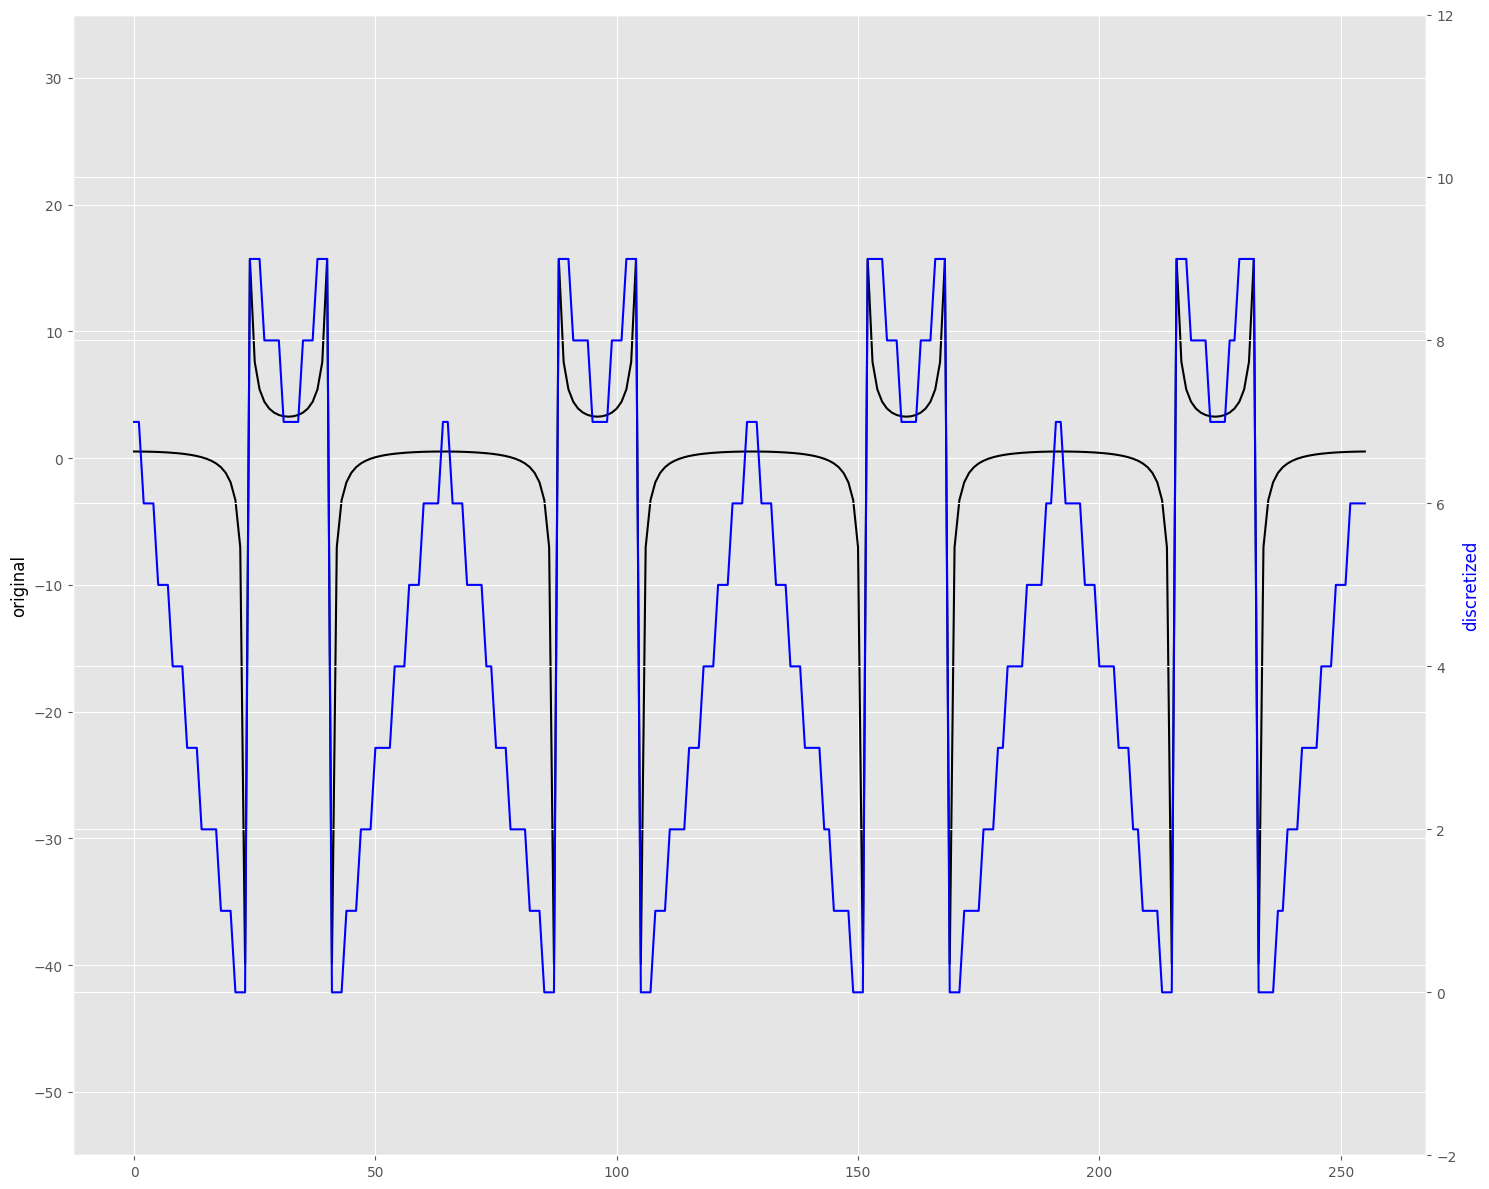

In [113]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

transformed_df = transformed.toPandas()

fig, ax1 = plt.subplots(figsize=(15,12))
ax2 = ax1.twinx()

ax1.plot(transformed_df['signal'], 'k')
ax2.plot(transformed_df['discretized'], 'b-')

ax1.set_ylabel('original', color='k')
ax2.set_ylabel('discretized', color='b')

ax1.set_ylim((-55, 35))
ax2.set_ylim((-2, 12))
fig.tight_layout()

#plt.savefig('discretized.png')

#plt.close('all')

plt.show()

### **Standardizing continuous variables**

In [114]:
signal_df.describe().show()

+-------+--------------------+
|summary|              signal|
+-------+--------------------+
|  count|                 256|
|   mean|-5.59448321002520...|
| stddev|   8.056325329550202|
|    min|    -39.878842775021|
|    max|  15.718058116309553|
+-------+--------------------+



In [115]:
from pyspark.ml import Pipeline
vec = feat.VectorAssembler(
    inputCols=['signal']
    , outputCol='signal_vec'
)

norm = feat.StandardScaler(
    inputCol=vec.getOutputCol()
    , outputCol='signal_norm'
    , withMean=True
    , withStd=True
)

norm_pipeline = Pipeline(stages=[vec, norm])
signal_norm = (
    norm_pipeline
    .fit(signal_df)
    .transform(signal_df)
)

signal_norm.take(1)

[Row(signal=0.5233399378711634, signal_vec=DenseVector([0.5233]), signal_norm=DenseVector([0.065]))]

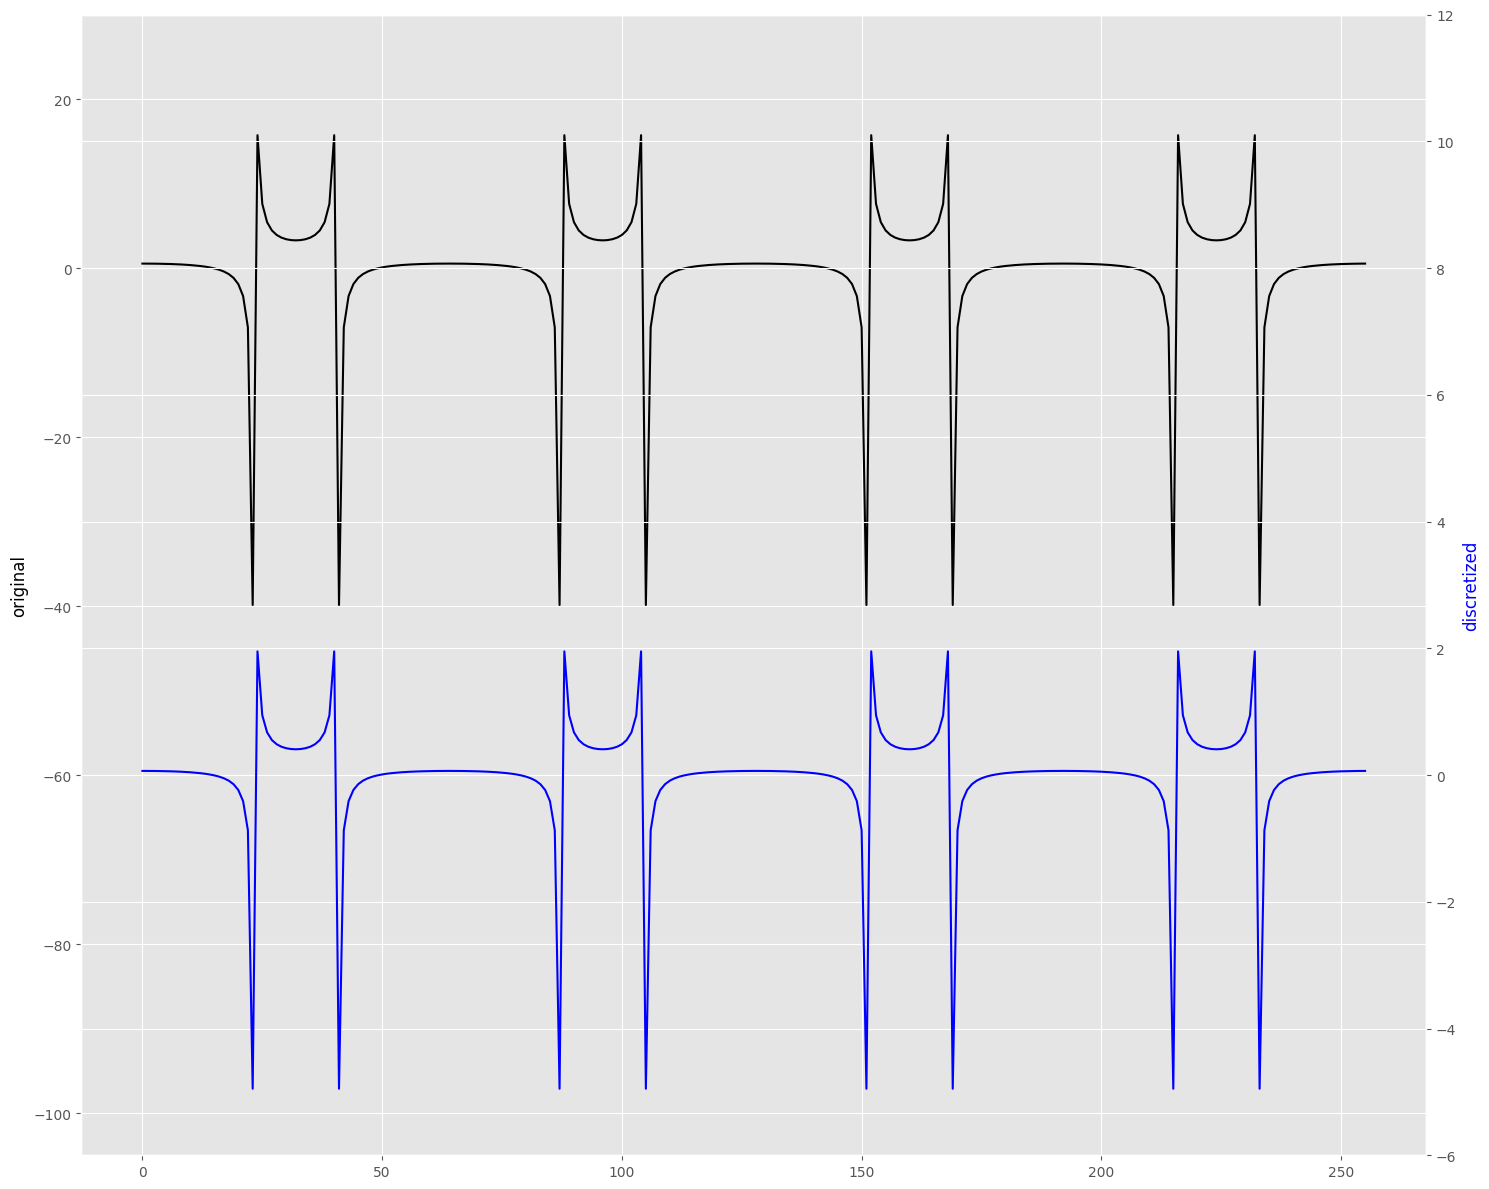

In [116]:
normalized_df = signal_norm.toPandas()
normalized_df['normalized'] = normalized_df.apply(lambda row: row[2][0], axis=1)

fig, ax1 = plt.subplots(figsize=(15,12))
ax2 = ax1.twinx()

ax1.plot(normalized_df['signal'], 'k')
ax2.plot(normalized_df['normalized'], 'b-')

ax1.set_ylabel('original', color='k')
ax2.set_ylabel('discretized', color='b')

ax1.set_ylim((-105, 30))
ax2.set_ylim((-6, 12))
fig.tight_layout()

#plt.savefig('normalized.png')

#plt.close('all')

plt.show()

### **Topic mining**

In [117]:
articles = spark.createDataFrame([
    ('''
        The Andromeda Galaxy, named after the mythological
        Princess Andromeda, also known as Messier 31, M31,
        or NGC 224, is a spiral galaxy approximately 780
        kiloparsecs (2.5 million light-years) from Earth,
        and the nearest major galaxy to the Milky Way.
        Its name stems from the area of the sky in which it
        appears, the constellation of Andromeda. The 2006
        observations by the Spitzer Space Telescope revealed
        that the Andromeda Galaxy contains approximately one
        trillion stars, more than twice the number of the
        Milky Way’s estimated 200-400 billion stars. The
        Andromeda Galaxy, spanning approximately 220,000 light
        years, is the largest galaxy in our Local Group,
        which is also home to the Triangulum Galaxy and
        other minor galaxies. The Andromeda Galaxy's mass is
        estimated to be around 1.76 times that of the Milky
        Way Galaxy (~0.8-1.5×1012 solar masses vs the Milky
        Way's 8.5×1011 solar masses).
    ''','Galaxy', 'Andromeda')
    , ('''
        The Milky Way is the galaxy that contains our Solar
        System. The descriptive "milky" is derived from the
        appearance from Earth of the galaxy – a band of light
        seen in the night sky formed from stars that cannot be
        individually distinguished by the naked eye. The term
        Milky Way is a translation of the Latin via lactea, from
        the Greek. From Earth, the Milky Way appears as a band
        because its disk-shaped structure is viewed from within.
        Galileo Galilei first resolved the band of light into
        individual stars with his telescope in 1610. Observations
        by Edwin Hubble showed that the Milky
        Way is just one of many galaxies.
    ''','Galaxy','Milky Way')
    , ('''
        Australia, officially the Commonwealth of Australia,
        is a sovereign country comprising the mainland of the
        Australian continent, the island of Tasmania and numerous
        smaller islands. It is the largest country in Oceania and
        the world's sixth-largest country by total area. The
        neighbouring countries are Papua New Guinea, Indonesia and
        East Timor to the north; the Solomon Islands and Vanuatu to
        the north-east; and New Zealand to the south-east. Australia's
        capital is Canberra, and its largest city is Sydney.
    ''','Geography', 'Australia')
    , ('''
        The United States of America (USA), commonly known as the United
        States (U.S.) or America, is a federal republic composed of 50
        states, a federal district, five major self-governing territories,
        and various possessions. At 3.8 million square miles (9.8 million
        km2) and with over 325 million people, the United States is the
        world's third- or fourth-largest country by total area and the
        third-most populous country. The capital is Washington, D.C., and
        the largest city by population is New York City. Forty-eight states
        and the capital's federal district are contiguous and in North America
        between Canada and Mexico. The State of Alaska is in the northwest
        corner of North America, bordered by Canada to the east and across
        the Bering Strait from Russia to the west. The State of Hawaii is
        an archipelago in the mid-Pacific Ocean. The U.S. territories are
        scattered about the Pacific Ocean and the Caribbean Sea, stretching
        across nine official time zones. The extremely diverse geography,
        climate, and wildlife of the United States make it one of the world's
        17 megadiverse countries.
    ''','Geography', 'USA')
    , ('''
        China, officially the People's Republic of China (PRC), is a unitary
        sovereign state in East Asia and, with a population of around 1.404
        billion, the world's most populous country. Covering 9,600,000
        square kilometers (3,700,000 sq mi), China has the most borders of
        any country in the world. Governed by the Communist Party of China,
        it exercises jurisdiction over 22 provinces, five autonomous regions,
        four direct-controlled municipalities (Beijing, Tianjin, Shanghai, and
        Chongqing), and the special administrative regions of Hong Kong and Macau.
    ''','Geography', 'China')
    , ('''
        Poland, officially the Republic of Poland, is a country located in
        Central Europe. It is divided into 16 administrative subdivisions,
        covering an area of 312,679 square kilometres (120,726 sq mi), and has
        a largely temperate seasonal climate. With a population of approximately
        38.5 million people, Poland is the sixth most populous member state of
        the European Union. Poland's capital and largest metropolis is
        Warsaw.
    ''','Geography', 'Poland')
    , ('''
        The domestic dog (Canis lupus familiaris when considered a subspecies
        of the gray wolf or Canis familiaris when considered a distinct species)
        is a member of the genus Canis (canines), which forms part of the
        wolf-like canids, and is the most widely abundant terrestrial carnivore.
        The dog and the extant gray wolf are sister taxa as modern wolves are
        not closely related to the wolves that were first domesticated, which
        implies that the direct ancestor of the dog is extinct. The dog was
        the first species to be domesticated and has been selectively bred over
        millennia for various behaviors, sensory capabilities, and physical attributes.
    ''','Animal', 'Dog')
    , ('''
        The origin of the domestic dog is not clear. It is known that the dog was
        the first domesticated species. The domestic dog is a member of the genus
        Canis (canines), which forms part of the wolf-like canids, and is the most
        widely abundant terrestrial carnivore. The closest living relative of the
        dog is the gray wolf and there is no evidence of any other canine
        contributing to its genetic lineage. The dog and the extant gray wolf
        form two sister clades, with modern wolves not closely related to the
        wolves that were first domesticated. The archaeological record shows
        the first undisputed dog remains buried beside humans 14,700 years ago,
        with disputed remains occurring 36,000 years ago. These dates imply
        that the earliest dogs arose in the time of human hunter-gatherers
        and not agriculturists.
    ''','Animal', 'Dog')
    , ('''
        Washington, officially the State of Washington, is a state in the Pacific
        Northwest region of the United States. Named after George Washington,
        the first president of the United States, the state was made out of the
        western part of the Washington Territory, which was ceded by Britain in
        1846 in accordance with the Oregon Treaty in the settlement of the
        Oregon boundary dispute. It was admitted to the Union as the 42nd state
        in 1889. Olympia is the state capital. Washington is sometimes referred
        to as Washington State, to distinguish it from Washington, D.C., the
        capital of the United States, which is often shortened to Washington.
    ''','Geography', 'Washington State')
], ['articles', 'Topic', 'Object'])

In [118]:
import pyspark.ml.clustering as clust

splitter = feat.RegexTokenizer(
    inputCol='articles'
    , outputCol='articles_split'
    , pattern='\s+|[,.\"]'
)

sw_remover = feat.StopWordsRemover(
    inputCol=splitter.getOutputCol()
    , outputCol='no_stopWords'
)

count_vec = feat.CountVectorizer(
    inputCol=sw_remover.getOutputCol()
    , outputCol='vector'
)

lda_clusters = clust.LDA(
    k=3
    , optimizer='online'
    , featuresCol=count_vec.getOutputCol()
)

topic_pipeline = Pipeline(
    stages=[
        splitter
        , sw_remover
        , count_vec
        , lda_clusters
    ]
)

for topic in (
        topic_pipeline
        .fit(articles)
        .transform(articles)
        .select('Topic','Object','topicDistribution')
        .take(10)
):
    print(
        topic.Topic
        , topic.Object
        , np.argmax(topic.topicDistribution)
        , topic.topicDistribution
    )


Galaxy Andromeda 2 [0.0023955334315973647,0.002619600290659077,0.9949848662777435]
Galaxy Milky Way 2 [0.003858094738729304,0.004175636024978901,0.9919662692362917]
Geography Australia 1 [0.005171489600950293,0.9888997473232867,0.005928763075763091]
Geography USA 1 [0.0020994516190887447,0.9954960725876282,0.0024044757932830756]
Geography China 1 [0.004036292363818158,0.9913585889085998,0.004605118727581911]
Geography Poland 1 [0.005301949560087051,0.9886178348036716,0.006080215636241321]
Animal Dog 0 [0.9908288960657207,0.004468361578146595,0.004702742356132706]
Animal Dog 0 [0.9934711903683053,0.00318276665471943,0.0033460429769752646]
Geography Washington State 1 [0.004236203407045512,0.9909048252252579,0.0048589713676964645]
